https://surpriselib.com/

In [1]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3156207 sha256=4c021f45dfaa8fe404c9324575c87fbc9f19086072924180fb2fc89fc1bc051b
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import surprise
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import train_test_split

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

In [4]:
links_df = pd.read_csv("/content/drive/MyDrive/Tobigs/Week9/ml-latest-small/links.csv", dtype=str)
movies_df = pd.read_csv("/content/drive/MyDrive/Tobigs/Week9/ml-latest-small/movies.csv")
ratings_df = pd.read_csv("/content/drive/MyDrive/Tobigs/Week9/ml-latest-small/ratings.csv")
tags_df = pd.read_csv("/content/drive/MyDrive/Tobigs/Week9/ml-latest-small/tags.csv")

#1. EDA & Preprocessing

In [5]:
links_df

,movieId,imdbId,tmdbId
0,1,0114709,862
1,2,0113497,8844
2,3,0113228,15602
3,4,0114885,31357
4,5,0113041,11862
...,...,...,...
9737,193581,5476944,432131
9738,193583,5914996,445030
9739,193585,6397426,479308
9740,193587,8391976,483455


links_df 데이터는 영화들의 imdb, tmdb ID를 갖고 있는 데이터이다. \
이번 과제에서는 영화의 링크를 통해 영화의 정보를 불러오지 않을 것이기 때문에 크게 필요하지 않은 데이터이다.

In [6]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


영화의 movieID, 제목과 개봉연도, 장르가 들어있는 데이터이다. 장르에 따른 추천을 진행할 수 있어 보인다.

In [7]:
ratings_df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


유저별로 평가한 영화의 평점(여러 개 평가 가능)과 평점을 매긴 시점인 timestamp를 보유한 데이터이다. \
rating을 이용하여 협업 필터링을 진행할 수 있어 보인다.

In [8]:
ratings_df = ratings_df.drop(['timestamp'], axis=1)

In [9]:
ratings_df['rating'].unique()

array([4. , 5. , 3. , 2. , 1. , 4.5, 3.5, 2.5, 0.5, 1.5])

<Axes: >

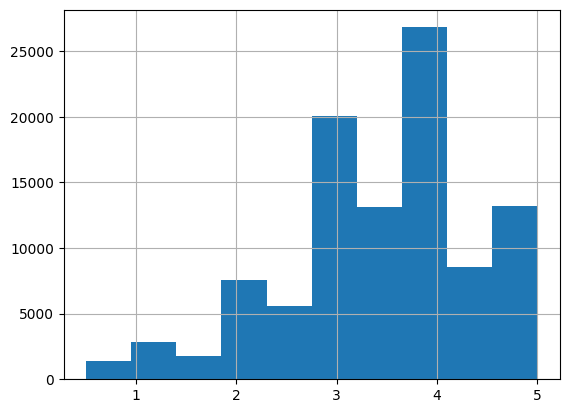

In [10]:
ratings_df['rating'].hist()

In [24]:
user_rating_table = ratings_df.set_index(["userId", "movieId"]).unstack()

In [25]:
user_rating_table = user_rating_table.fillna("")
user_rating_table

rating                                                            ...  \
movieId      1   10 100 100044 100068 100083 100106 100159 100163 100194  ...   
userId                                                                    ...   
1          4.0                                                            ...   
2                                                                         ...   
3                                                                         ...   
4                                                                         ...   
5          4.0                                                            ...   
...        ...  ...  ..    ...    ...    ...    ...    ...    ...    ...  ...   
606        2.5                                                            ...   
607        4.0                                                            ...   
608        2.5  4.0                                                       ...   
609        3.0  4.0                                                       ...   
610        5.0                           3.5           4.5    3.0         ...   

                                                                 
movieId 99750 99764 998 99813 99846 99853 999 99910 99917 99992  
userId                                                           
1                                                                
2                                                                
3                                                                
4                                                                
5                                                                
...       ...   ...  ..   ...   ...   ...  ..   ...   ...   ...  
606                                                              
607                                                              
608                                                              
609                                                              
610                                                   3.0        

[610 rows x 9724 columns]

In [13]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


In [14]:
len(tags_df['userId'].unique())

58

In [15]:
len(tags_df['tag'].unique())

1589

유저별로 여러 영화에 대한 태그를 작성한 데이터이다. \
영화에 태깅을 한 유저의 수가 58명밖에 되지 않는다.

In [16]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [17]:
def add_rating(df):
    ratings_df['movieId'] = ratings_df['movieId'].astype(str)
    agg_df = ratings_df.groupby('movieId').agg(
        rating_count = ('rating', 'count'),
        rating_avg = ('rating', 'mean')
    ).reset_index()

    rating_added_df = df.merge(agg_df, on='movieId')
    return rating_added_df

In [18]:
movies_df['movieId'] = movies_df['movieId'].astype(str)
merged_df = movies_df.merge(links_df, on='movieId', how='left')

result_df = add_rating(merged_df)

In [19]:
result_df

,movieId,title,genres,imdbId,tmdbId,rating_count,rating_avg
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0114709,862,215,3.920930
1,2,Jumanji (1995),Adventure|Children|Fantasy,0113497,8844,110,3.431818
2,3,Grumpier Old Men (1995),Comedy|Romance,0113228,15602,52,3.259615
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0114885,31357,7,2.357143
4,5,Father of the Bride Part II (1995),Comedy,0113041,11862,49,3.071429
...,...,...,...,...,...,...,...
9719,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,5476944,432131,1,4.000000
9720,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,5914996,445030,1,3.500000
9721,193585,Flint (2017),Drama,6397426,479308,1,3.500000
9722,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,8391976,483455,1,3.500000


영화들의 rating 횟수와 rating의 평점을 저장하여 협업 필터링을 진행할 최종적인 result_df 데이터프레임을 제작하였다.

https://hipster4020.tistory.com/115
https://datainclude.me/posts/%EC%84%9C%ED%94%84%EB%9D%BC%EC%9D%B4%EC%A6%88(Surprise)%EB%A5%BC_%EC%82%AC%EC%9A%A9%ED%95%9C_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C(Recommendations)/
https://big-dream-world.tistory.com/70
https://techblog-history-younghunjo1.tistory.com/117
https://data-science-hi.tistory.com/80


#2. Memory based CF
사용자 기반 협업 필터링(User-based CF) \

In [20]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [21]:
reader = surprise.Reader(rating_scale=(0.5, 5.0))
data = surprise.Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [28]:
sim_options = {'name': 'pearson_baseline', 'user_based': True}

algo_KNNwithMeans = surprise.KNNWithMeans(sim_options=sim_options)
surprise.model_selection.cross_validate(algo_KNNwithMeans, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.90834196, 0.90861127, 0.91279457]),
 'fit_time': (0.25125765800476074, 0.2818598747253418, 0.40981101989746094),
 'test_time': (1.9237580299377441, 2.2864761352539062, 2.842862367630005)}

In [30]:
trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.25)

algo_KNNwithMeans.fit(trainset)

predictions = algo_KNNwithMeans.test(testset)

surprise.accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9035


0.903539555552753

In [31]:
sim_options = {'name': 'pearson_baseline', 'user_based': True}

algo_KNNBaseline = surprise.KNNBaseline(sim_options=sim_options)
surprise.model_selection.cross_validate(algo_KNNBaseline, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


{'test_rmse': array([0.88488129, 0.88996167, 0.8930411 ]),
 'fit_time': (0.2466602325439453, 0.2310655117034912, 0.3874781131744385),
 'test_time': (2.5364534854888916, 5.026955842971802, 2.7962663173675537)}

In [32]:
trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.25)

algo_KNNBaseline.fit(trainset)

predictions = algo_KNNBaseline.test(testset)

surprise.accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.8774


0.8773584161357664

#3. Model based CF
아이템 기반 협업 필터링(Item-based CF)

In [33]:
algo_SVD = surprise.SVD()
surprise.model_selection.cross_validate(algo_SVD, data, measures=['RMSE'], cv=3, verbose=False)

{'test_rmse': array([0.88045784, 0.8787053 , 0.87871136]),
 'fit_time': (2.0712361335754395, 1.0705440044403076, 1.3863146305084229),
 'test_time': (0.35297203063964844, 0.3583211898803711, 0.22446393966674805)}

In [34]:
trainset, testset = surprise.model_selection.train_test_split(data, test_size=0.25)

algo_SVD.fit(trainset)

predictions = algo_SVD.test(testset)

surprise.accuracy.rmse(predictions)

RMSE: 0.8747


0.8747310780384107